In [3]:
# all necessary includes

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

import os
import nltk
# nltk.download('stopwords')

In [2]:
# additional functions

garbage_words = stopwords.words('english') + stopwords.words('russian')


# will split dataframe into samples with same proportion of each document class
def SplitTrainSample(dataframe, fraction=0.7):
    '''
    1) to form arrays for each document class
    2) to split each class by np.split
    3) to shuffle rows in resulting dataframe1 and dataframe2
    '''
    types = set(dataframe['target'])
    print(types)
    dataframes = [dataframe[dataframe['target'] == doc_type] for doc_type in types]
    splited = [np.split(df.sample(frac=1), [int(fraction * len(df))]) for df in dataframes]
    test = [df[0] for df in splited]
    train = [df[1] for df in splited]
    return pd.concat(train).sample(frac=1), pd.concat(test).sample(frac=1)


def ClearText(text, garbage_words):
    result = [word for word in text.lower().split() if word not in garbage_words]
    return ' '.join(result)


def CreateVectorizer(ngram_range, max_features):
    return CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )



def TrainRandomForestClassifier(dataframe, n_estimators=300):
    ngram_range = (1, 3)
    max_features = 50000

    vectorizer = CreateVectorizer(ngram_range, max_features)
    X_train, Y_train = dataframe['X'], dataframe['target']
    
    X_train = vectorizer.fit_transform(X_train)
    #print(X_train.shape)
    #print(type(X_train))
    # X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)
    model = model.fit(X_train, Y_train)
    return vectorizer, model


def BuildDataFrame(cur_folder, doc_types, file_names, doc_texts, name=''):
    files = os.listdir()
    cur_name = name[:]
    if len(cur_name) != 0:
        cur_name += '-'
    cur_name += cur_folder
    if 'text_layer' in files:
        files.remove('text_layer')
        print('in', cur_name)
        
    folders = [file for file in files if '.' not in file]
    
    for folder in folders:
        os.chdir(folder)
        BuildDataFrame(folder, doc_types, file_names, doc_texts, cur_name)
        os.chdir('..')
    if len(folders) == 0:
        for file in files:
            text_layer = ''
            if 'text_layer' in os.listdir():
                try:
                    with open('./text_layer/' + file.split('.')[0] + '.txt') as f:
                        text_layer = f.read()
                except:
                    NOT_FOUND.append((file, cur_name))
            if len(text_layer) > 0:
                doc_texts.append(text_layer)
                doc_types.append(cur_name)
                file_names.append(file)
        

In [3]:
#os.chdir('..')
print(os.listdir())

['.ipynb_checkpoints', '1 - Accounting docs', '2 - Security prospectus', '3 - RFQ Emails', '4 - Telecom requests', '5 - Government requests', '6 - Unknown', 'DOCUMENT_CLASSIFIER.ipynb', 'for training', 'models', 'outlook message extractor.ipynb']


In [4]:
# read input
NOT_FOUND = []
doc_types, file_names, doc_texts = [], [], []

dataset_path = 'for training'
os.chdir(dataset_path)
BuildDataFrame('', doc_types, file_names, doc_texts)
os.chdir('..')
df = pd.DataFrame({'file_name': file_names, 'doc_type': doc_types, 'doc_text' : doc_texts})
# print(df)

in ad-error
in ad-invoice-first
in ad-invoice-multi
in ad-statement-first
in ad-statement-multi
in ad-upd-first
in ad-upd-multi
in ad-waybill-first
in ad-waybill-multi
in rfq-AOG
in rfq-CRITICAL
in rfq-Routine
in rfq-Spam
in sec-error
in sec-Изменение контроля
in sec-Кросс-дефолт
in sec-Обозначение прав дочерних компаний
in sec-Оговорки о коллективных действиях
in sec-Ограничение деятельности
in sec-Ограничение задолженности
in sec-Ограничение задолженности дочерних компаний
in sec-Ограничение по инвестициям
in sec-Ограничение по наслоению долговых обязательств по рангам
in sec-Ограничение по платежам
in sec-Ограничение по платежам в отношении дочерних компаний
in sec-Ограничение по предоставлению залога
in sec-Ограничение по продаже активов
in sec-Ограничение по продаже активов с обратной арендой
in sec-Ограничение по слиянию
in sec-Ограничение по транзакциям с аффилированными лицами
in sec-Случаи дефолта
in sec-Триггер рейтингов
in sec-Условие приостановки действия ковенантов
in sec-

In [5]:
# part for checking files that weren't found
ext = [x[0].split('.')[-1] for x in NOT_FOUND]
print(set(ext))
formated_not_found = ['file {} at {} not found'.format(x[0], x[1]) for x in NOT_FOUND if '' in x[0].split('.')[-1].lower()]
print(len(formated_not_found))
#print('\n'.join(formated_not_found))

{'pdf', 'JPEG', 'jpg', 'PDF', 'msg'}
49


In [6]:
# modify input

for i in range(len(df['doc_text'])):
    df['doc_text'][i] = ClearText(df['doc_text'][i], garbage_words)
df = df.rename(columns={'doc_type' : 'target', 'doc_text' : 'X'})
# print(df)

In [7]:
len(df)

24367

In [7]:
# split into training (0.6 of dataframe) validation (0.2 of dataframe) and test (0.2 of dataframe)

train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
# train, test = SplitTrainSample(df, fraction=0.7)

In [8]:
def CalculateAccuracy(ds, confidence_level):
    ds['predict'] = model.predict(vectorizer.transform(ds['X']))
    ds['confidence'] = np.transpose(np.amax(model.predict_proba(vectorizer.transform(ds['X'])), axis=1))

    precision = round(100 * len(ds[(ds['confidence'] >= confidence_level) & (ds['target'] == ds['predict'])]) / len(ds), 2)
    to_validate = round(100 * len(ds[(ds['confidence'] < confidence_level)]) / len(ds), 2)
    return precision, to_validate, confidence_level

In [4]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=90, stop=250, num=50)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=15, stop=50, num=15)]
min_samples_split = [int(x) for x in np.linspace(start=20, stop=50, num=15)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=5)]
bootstrap = [True, False]
param_dist = {
    'rf_clf__n_estimators' : n_estimators,
    'rf_clf__max_features' : max_features,
    'rf_clf__max_depth' : max_depth,
    'rf_clf__min_samples_split' : min_samples_split,
    'rf_clf__min_samples_leaf' : min_samples_leaf,
    'rf_clf__bootstrap' : bootstrap,
    'tfidf__strip_accents': ['ascii', 'unicode', None],
    'tfidf__ngram_range': [(1,2), (2,3), (3,4)],
    'tfidf__max_features' : [10000, 20000, 50000]
}

from sklearn.pipeline import Pipeline
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
rf_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf_clf', RandomForestClassifier())])

rf_ppl_cv = Pipeline([
    ('cntvec', CountVectorizer()),
    ('rf_clf', RandomForestClassifier())])

In [59]:
dataframe = train.copy()
vectorizer = CreateVectorizer((1, 3), 50000)
X_train, Y_train = dataframe['X'], dataframe['target']
X_train = vectorizer.fit_transform(X_train)

In [65]:
# rf = RandomForestClassifier()
random_searcher = RandomizedSearchCV(rf_ppl_clf,
                                    param_dist,
                                    n_iter=90,
                                    cv=3,
                                    verbose=1,
                                    n_jobs=1,
                                    random_state=0)
random_searcher.fit(X_train, Y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=90,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [15, 17, 20, 22, 25, 27,
                                                      30, 32, 35, 37, 40, 42,
                                                      45, 47, 50],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 10],
                                        'min_samples_split': [20, 22, 24, 26,
                                                              28, 30, 32, 35,
                                                              37, 39, 41, 43,
                                                              45, 47, 50],
                                        'n_estimators': [90, 93, 96, 99, 103,
                                                         106, 109, 11

In [66]:
random_searcher.best_params_

{'n_estimators': 112,
 'min_samples_split': 35,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [67]:
rs_df = pd.DataFrame(random_searcher.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'mean_score_time',
    'params',
    'split0_test_score',
    'split1_test_score',
    'split2_test_score',
    'std_test_score'
], axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,112,35,1,sqrt,50,False,0.893859,1
1,220,47,1,sqrt,50,False,0.891397,2
2,112,35,1,sqrt,40,False,0.887395,3
3,220,43,1,sqrt,42,False,0.886780,4
4,230,20,1,sqrt,42,True,0.885908,5
5,178,32,3,sqrt,42,False,0.883189,6
6,132,50,1,sqrt,35,False,0.882522,7
7,103,47,1,sqrt,42,True,0.882111,8
8,171,37,3,sqrt,40,False,0.882111,9
9,112,32,1,sqrt,37,True,0.880983,10


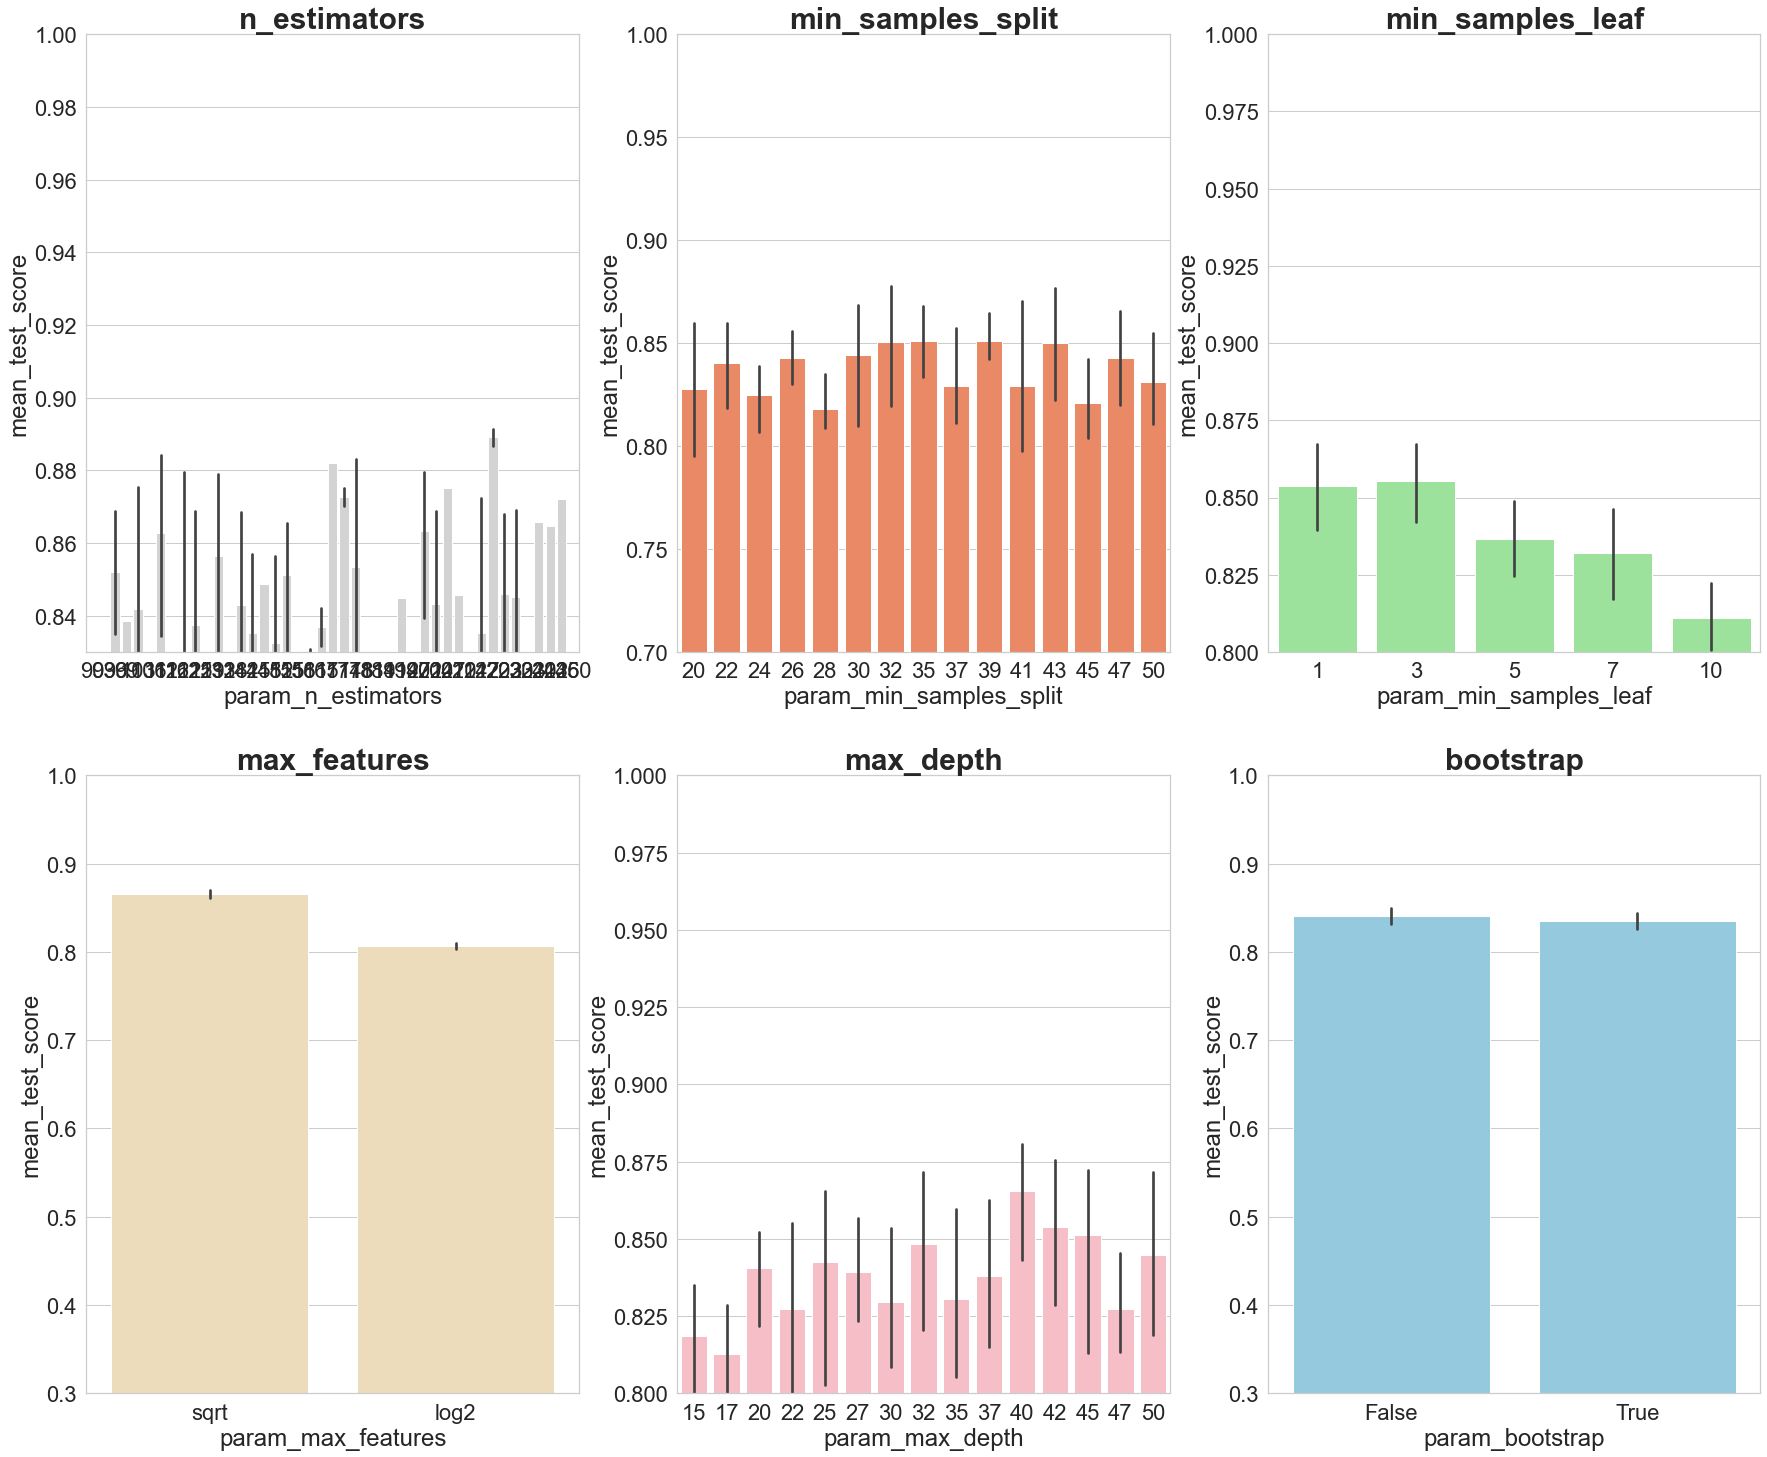

In [68]:
colors = ['lightgrey', 'coral', 'lightgreen', 'wheat', 'lightpink', 'skyblue', 'forestgreen', 'maroon', 'olivedrab']
params = list(param_dist.keys())
ncols, nrows = 2, 4
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30, 30)

for ind in len(params):
    i = ind / nrows
    j = ind % ncols
    sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[i, j], color=colors[ind])
    axs[i, j].set_ylim([.7, 1])
    axs[i, j].set_title(label = params[ind], size=30, weight='bold')

    
'''
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83, 1])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.7, 1])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80, 1])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.3, 1])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80, 1])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.3, 1])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
'''

plt.show()

In [69]:
model = random_searcher.best_estimator_

#best = random_searcher.best_params_
#model = RandomForestClassifier(n_estimators=best['n_estimators'], 
#                               min_samples_split=best['min_samples_split'], 
#                               min_samples_leaf=best['min_samples_leaf'], 
#                               max_features=best['max_features'], 
#                               max_depth=best['max_depth'], 
#                               bootstrap=False)
#model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_split=35, n_estimators=112)

In [ ]:
from sklearn.model_selection import GridSearchCV
n_estimators = [100, 150, 200]
max_features = ['sqrt']
max_depth = [40, 42, 45]
min_samples_split = [32, 35, 43]
min_samples_leaf = [1, 3]
bootstrap = [False, True]
param_grid = {
    'rf_clf__n_estimators' : n_estimators,
    'rf_clf__max_features' : max_features,
    'rf_clf__max_depth' : max_depth,
    'rf_clf__min_samples_split' : min_samples_split,
    'rf_clf__min_samples_leaf' : min_samples_leaf,
    'rf_clf__bootstrap' : bootstrap,
    'tfidf__strip_accents':['ascii', 'unicode', None],
    'tfidf__ngram_range':[(1,2), (2,3), (3,4)],
    'tfidf__max_features' : [10000, 20000, 50000]
}
gs = GridSearchCV(rf_ppl_clf, param_grid, cv = 3, verbose = 1, n_jobs=1)
gs.fit(X_train, Y_train)
model = gs.best_estimator_
gs.best_params_

In [27]:
# here will be cross validation by n_estimators, mb cross validation for vectorizer is necessary too

n_estimators = [30, 50, 100]
best_precision = 0
best_arg = 100

for n in n_estimators:
    vectorizer, model = TrainRandomForestClassifier(train, n_estimators=n)
    precision, to_validate, confidence_level = CalculateAccuracy(test.copy(), 0.8)
    prediction = model.predict(vectorizer.transform(test['X']))
    probability = model.predict_proba(vectorizer.transform(test['X']))
    accuracy = round(100 * np.mean(prediction == test['target']), 2)
    print('{} estimators, precision: {}, accuracy: {}'.format(n, precision, accuracy))
    if precision > best_precision:
        best_precision = precision
        best_arg = n

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


100 estimators, precision: {}, accuracy: {} 89.52 0.908494050061551


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


300 estimators, precision: {}, accuracy: {} 89.39 0.9097250718096019


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


500 estimators, precision: {}, accuracy: {} 89.36 0.908494050061551


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


700 estimators, precision: {}, accuracy: {} 89.19 0.9097250718096019


In [28]:
print(best_arg, best_precision)

100 89.52


In [29]:
# train the model
best_arg = 100
vectorizer, model = TrainRandomForestClassifier(train, n_estimators=best_arg)

In [30]:
# write model to file
if 'models' not in os.listdir():
    os.mkdir('models')
with open('./models/doc_classifyer-model', 'wb') as f:
    pickle.dump(model, f)
with open('./models/doc_classifyer-vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [80]:
with open('./models/doc_classifyer-model', 'rb') as f:
    model = pickle.load(f)
with open('./models/doc_classifyer-vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)

In [70]:
# assess accuracy of the model
from sklearn.metrics import classification_report, accuracy_score

precision, to_validate, confidence_level = CalculateAccuracy(test.copy(), 0.8)

print('Rows in test set: {}'.format(len(test)))
print('Statistics:')
print('Precision = {}%; Ratio of wrong answers = {}%; at confidence level = {}'.format(precision, to_validate, confidence_level))
print('Mean accuracy: {}%'.format(round(100 * accuracy_score(test['target'], prediction), 2)))
print(classification_report(test['target'], prediction))

Rows in test set: 4874
Statistics:
Precision = 73.2%; Ratio of wrong answers = 25.26%; at confidence level = 0.8
Mean accuracy: 83.73%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.92      0.90      0.91       835
                                            ad-invoice-multi       0.91      0.51      0.65       116
                                          ad-statement-first       0.97      0.98      0.97      1139
                                          ad-statement-multi       0.99      0.68      0.81       156
                                                ad-upd-first       0.88      0.94      0.91       673
                                                ad-upd-multi       0.83      0.70      0.76       142
                                            ad-waybill-first       0.94      0.94      0.94       307
                                            ad-w

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
